In [1]:
import sys
sys.path.append("..")
import numpy as np

from cryoem.plots import plot_images, plot_iterations_polar_plot, plot_iterations_rotvec, plot_euclidean_space
from cryoem.conversions import quaternion2euler
from cryoem.angle_alignment import training_angle_alignment, update_quaternion
from tensorflow.keras.optimizers import Adagrad, Ftrl

In [2]:
projections = np.load("3-reconstruction/data/projections_estimated_le0.5_50k.npy")
angles_true = np.load("3-reconstruction/data/angles_true_estimated_le0.5_50k.npy")

---

# Estimated Distances

# Limit 0.5

In [3]:
data = np.load("3-reconstruction/data/angle_recovery_estimated_le0.5_50k.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

angles_predicted = quaternion2euler(q_predicted)

In [ ]:
# TODO: plot only dots plot

In [4]:
plot_images(angles_predicted, projections, indices=range(100), img_size_scale=0.05)

In [5]:
plot_iterations_polar_plot(q_all, angles_true, interval=1, connections=False, selected=None)

In [6]:
plot_iterations_rotvec(q_all, angles_true, interval=1)

In [4]:
plot_euclidean_space(angles_predicted)

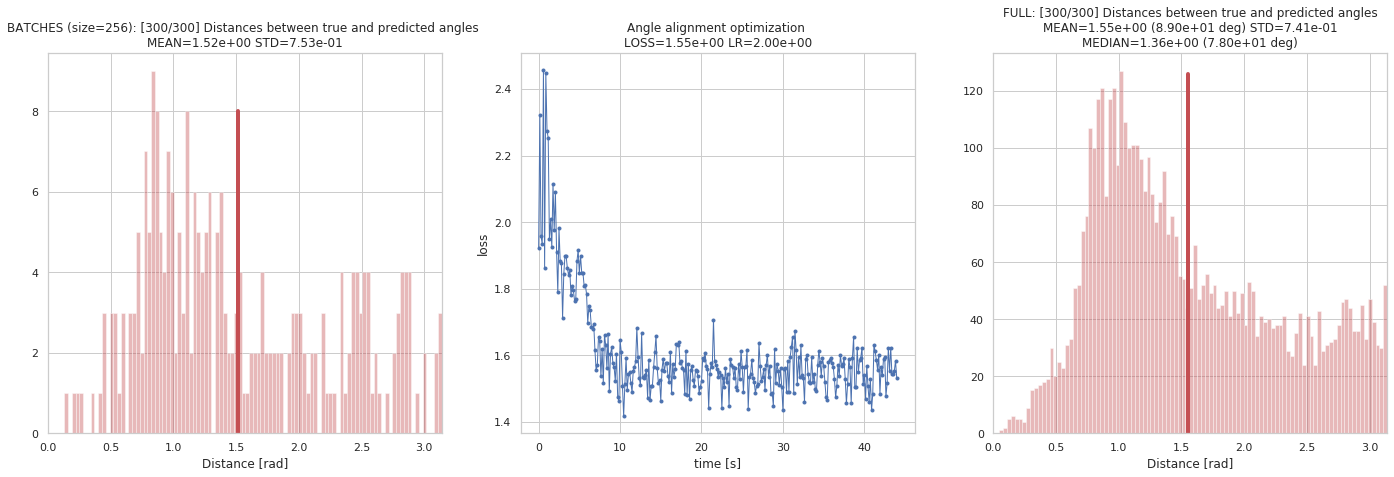

step 30/300 (4s): loss = 1.98e+00
step 60/300 (9s): loss = 1.71e+00
step 90/300 (13s): loss = 1.55e+00
step 120/300 (17s): loss = 1.56e+00
step 150/300 (22s): loss = 1.55e+00
step 180/300 (26s): loss = 1.54e+00
step 210/300 (30s): loss = 1.53e+00
step 240/300 (36s): loss = 1.56e+00
step 270/300 (41s): loss = 1.55e+00
step 300/300 (45s): loss = 1.55e+00



In [4]:
m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
                                                        steps=300, 
                                                        batch_size=256, 
                                                        optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
                                                        angles_true=angles_true, 
                                                        angles_predicted=angles_predicted)

In [7]:
collect_data.shape

(30, 5000, 4)

In [13]:
import matplotlib.pyplot as plt
import ipyvolume as ipv
from cryoem.rotation_matrices import RotationMatrix
from scipy.spatial.transform import Rotation as R
import numpy as np
import tensorflow as tf
import seaborn as sns; sns.set(style="white", color_codes=True)
import pandas as pd
from matplotlib._png import read_png
from cryoem.conversions import euler2quaternion, d_q

In [24]:
def plot_iterations_polar_plot(q_all, angles_true, interval=1, connections=True, selected=None):
    if q_all.shape[1] != angles_true.shape[0]:
        raise Exception("Should specify the same number of true angles and predicted angles")
    
    if not selected:
        selected = range(len(angles_true))
        
    ipv.clear()
    angles_predicted_all = np.zeros((*q_all.shape[0:2], 3))
    for i, q in enumerate(q_all):
        angles_predicted_all[i, :] = R.from_quat(q).as_euler("zyz")% (2*np.pi)
    
    print(angles_predicted_all.shape)
        
    # PREDICTED ANGLES ITERATION    
    xyz = np.zeros(angles_predicted_all.shape)
    for i, a in enumerate(angles_predicted_all):
        z0, y1, z1 = a[:,0], a[:,1], a[:,2]
        x = z1*np.sin(y1)*np.cos(z0)
        y = z1*np.sin(y1)*np.sin(z0)
        z = z1*np.cos(y1)
        xyz[i,:,:] = np.array([x, y, z]).T
        
    # TRUE ANGLES
    xyz_true = np.zeros(angles_true.shape)
    z0, y1, z1 = angles_true[:,0], angles_true[:,1], angles_true[:,2]

    x = z1*np.sin(y1)*np.cos(z0)
    y = z1*np.sin(y1)*np.sin(z0)
    z = z1*np.cos(y1)

    xyz_true = np.array([x, y, z]).T
    
    xyz_true = np.take(xyz_true, selected, axis=0)
    xyz = np.take(xyz, selected, axis=1)
    xyzt = np.stack((xyz_true,)*len(xyz), axis=0)
    
    N = len(selected)
    steps = len(xyz)
    x = np.zeros((steps, 2*N))
    y = np.zeros((steps, 2*N))
    z = np.zeros((steps, 2*N))
    
    x[0] = np.concatenate([xyz_true[:,0], xyz[0,:,0]])
    y[0] = np.concatenate([xyz_true[:,1], xyz[0,:,1]])
    z[0] = np.concatenate([xyz_true[:,2], xyz[0,:,2]])
    for i in range(1, steps):
        x[i] = np.concatenate([xyz_true[:,0], xyz[i,:,0]])
        y[i] = np.concatenate([xyz_true[:,1], xyz[i,:,1]])
        z[i] = np.concatenate([xyz_true[:,2], xyz[i,:,2]])
    
    ipv.figure()
    lines = [[i, i+N] for i in range(len(selected))]
    s = ipv.scatter(x, y, z, color="blue", marker="sphere")
    d = ipv.scatter(xyz_true[:,0], xyz_true[:,1], xyz_true[:,2], marker="sphere", color="red", size=2)
    if connections:
        p = ipv.plot_trisurf(x, y, z, lines=lines);
        ipv.animation_control([d,s, p], interval=interval)
    else:
        ipv.animation_control([d,s], interval=interval)

    ipv.xlim(-2*np.pi, 2*np.pi);ipv.ylim(-2*np.pi, 2*np.pi);ipv.zlim(-2*np.pi, 2*np.pi);
    ipv.show()

In [25]:
plot_iterations_polar_plot(collect_data, angles_true, interval=100, connections=False, selected=None)

(30, 5000, 3)


---

# Limit 2.0

In [6]:
data = np.load("3-reconstruction/data/angle_recovery_estimated_le2_50k.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

angles_predicted = quaternion2euler(q_predicted)

In [8]:
plot_images(angles_predicted, projections, indices=range(100), img_size_scale=0.05)

In [9]:
plot_iterations_polar_plot(q_all, angles_true, interval=1, connections=False, selected=None)

In [10]:
from cryoem.angle_recovery import angles_transpose

In [11]:
plot_iterations_rotvec(q_all, angles_true, interval=1)

In [7]:
plot_euclidean_space(angles_predicted)

---

# Limit 2.5

In [12]:
# data = np.load("3-reconstruction/data/angle_recovery_limited2.5_estimated_50k.npz")
# q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

# angles_predicted = quaternion2euler(q_predicted)

In [13]:
# plot_images(angles_predicted, projections, indices=range(100), img_size_scale=0.05)

In [14]:
# plot_iterations_polar_plot(q_all, angles_true, interval=1, connections=False, selected=None)

In [15]:
# plot_iterations_rotvec(q_all, angles_true, interval=1)

---

# Perfect Distances + Variance 0.8

# Limit 0.5

In [8]:
data = np.load("3-reconstruction/data/ar_perfect_le0.5_50k.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

angles_predicted = quaternion2euler(q_predicted)

In [17]:
plot_images(angles_predicted, projections, indices=range(100), img_size_scale=0.05)

In [18]:
plot_iterations_polar_plot(q_all, angles_true, interval=1, connections=False, selected=None)

In [19]:
from cryoem.angle_recovery import angles_transpose

In [20]:
plot_iterations_rotvec(q_all, angles_true, interval=1)

In [9]:
plot_euclidean_space(angles_predicted)

---

# Limit 2.0

---

# Limit 2.5

In [10]:
data = np.load("3-reconstruction/data/ar_perfect_le2.5_50k.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

angles_predicted = quaternion2euler(q_predicted)

In [22]:
plot_images(angles_predicted, projections, indices=range(100), img_size_scale=0.05)

In [23]:
plot_iterations_polar_plot(q_all, angles_true, interval=1, connections=False, selected=None)

In [24]:
from cryoem.angle_recovery import angles_transpose

In [25]:
plot_iterations_rotvec(q_all, angles_true, interval=1)

In [11]:
plot_euclidean_space(angles_predicted)

---